NFL League MVP Analysis by Rory Kavanagh

The NFL league MVP is an award given to the player deemed to be the best and most valuable player in a single season. Since its introduction in 1957, 65% of winners have been quarterbacks. In the past 20 years, the game has evolved to passing the ball more often and this can be seen with 80% of the last 20 winners being quarterbacks.

This analysis will discover the necessary statistics that quarterbacks must achieve in order to be considered for the award and also show the necessary data science techniques used in order to achieve this analysis.

The data for this analysis was obtained via the nflgame python library. This is an API that can be used to access player data from 2009 to 2015. In the years from 2009 to 2015, every winner has been a quarterback apart from in 2013 when Adrian Peterson won it for rushing for the 2nd most yards ever in a single season and only 9 yards short of breaking the record itself. 

The nflgame library was installed on the anaconda distribution and accessed via:

In [91]:
import nflgame
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The years of quarterbacks winning the MVP award and the year's respective winners were stored in two lists, years and mvps

In [92]:
# Winning years of Quarterback MVPs
years = [2009, 2010, 2011, 2013, 2014, 2015]

# List of Quarterback MVPs
mvps = ['P.Manning', 'T.Brady', 'A.Rodgers',
        'P.Manning', 'A.Rodgers', 'C.Newton']

The quarterback stats were called using the nflgame API. This was done via a method that returned important stats such as the quarterback's name, team, yards thrown, team, total number of touchdowns, total number of turnovers and their rating. The quarterback rating is a formula devised by the NFL to measure the performance of a quarterback.

In [93]:
#Calculate QB rating formula (NFL formula)
def qbr(cmp, att, yrds, int, tds):
    a = ((cmp/att) - 0.3) * 5
    b = ((yrds/att) - 3) * 0.25
    c = (tds/att) * 20
    d = 2.375 - ((int/att) * 25)

    a = num_check(a)
    b = num_check(b)
    c = num_check(c)
    d = num_check(d)

    rating = ((a+b+c+d)/6) * 100
    return rating

#Part of NFL QB Rating formula
def num_check(num):
    if num >= 2.375:
        num = 2.375
    elif num <= 0:
        num = 0
    else:
        num = num
    return num

#Retrieve QB stats per year
def get_qb_stats(year, players):
    #Lists to hold each stat type
    names = []
    yards = []
    rat = []
    team = []
    total_tds = []
    total_turnovers = []

    #Calling the API for player stats for a given year
    #Retriving QB stats based on QBs with at least 200 passing attempts
    passers = players.passing().filter(passing_att=lambda x: x >= 200).sort('passing_yds')

    for p in passers:
        names.append(p.name)
        yards.append(p.passing_yds)
        rat.append(qbr(p.passing_cmp, p.passing_att, p.passing_yds, p.passing_ints, p.passing_tds))
        team.append(get_team(p.name, players))
        total_tds.append(p.passing_tds + p.rushing_tds)
        total_turnovers.append(p.passing_ints + p.fumbles_lost)


    #Creating the dataframe to add the QB stats to
    passing_data = pd.DataFrame({'Player': names, 'Team': team, 'Yards': yards, 'Rating': rat, 'Year': year,
                                 'Touchdowns': total_tds, 'Turnovers': total_turnovers})
    return passing_data

#Method to find which team a player plays for
def get_team(qb, players):
    player = players.name(qb)
    team = player.team
    return team

Another important statistic that played a big factor in the MVP award was the winning record of the player. Only 1 player has won the MVP award between 2009 and 2015 with their team not having the most wins in their respective conference for the given season. That player was Adrian Peterson and his 2013 season.

A method was created to calculate the number of wins and losses per MVP winner per season. 

In [94]:
# Method to calculate the number of wins per player per season
def get_win_record(games, players, mvps):
    win_list = []
    loss_list = []
    team_list = []
    qb_list = []

    wins = 0
    losses = 0

    qb_list.append(mvps)
    team = get_team(mvps, players)
    team_list.append(team)

    for g in games:
        if g.winner == team:
            wins = wins + 1
        elif g.loser == team:
            losses = losses + 1

    win_list.append(wins)
    loss_list.append(losses)
    win_loss_record = pd.DataFrame({'Player': qb_list, 'Team': team_list,
                                    'Wins': win_list, 'Losses': loss_list})
    return win_loss_record

One of the key metrics in the NFL for measuring success of offences, defenses and players is yards gained or lost. While the explicit yard gain for quarterbacks varies year to year, what is compared year to year is the ranking of most yard per quarterback per year. The get_yards_index method was created to return the ranking of each quarterback's passing yards per season. 
The same logic was applied in order to get the ranking of the MVP's number of touchdowns and quarterback rating for their winning season.

In [95]:
def get_index(df, year, mvp, players, search_metric):
    index_list = []
    qb_list = []
    team_list = []
    count = 1
    if search_metric in df:
        df = df.sort_values(by=['Year', search_metric], ascending=[True, False])
        metric = (df.loc[(df['Player'] == mvp) & (df['Year'] == year)]).filter(items=[search_metric])
        temp_df = (df.loc[(df['Year'] == year)]).filter(items=[search_metric])
        for index, row in temp_df.iterrows():
            if metric.iloc[0].item() == row.item():
                index_list.append(count)
                qb_list.append(mvp)
                team_list.append(get_team(mvp, players))
                break
            else:
                count = count + 1
        metric_df = pd.DataFrame({'Player': qb_list, 'Team': team_list,
                                  search_metric + ' Index': index_list})
        return metric_df
    else:
        print('Metric does not exist for ', search_metric)

A dataframe is then created to store the information returned from the get_qb_stats method. A number of lists were created to store each of the MVPs statistics for each year. These would later be concatenated into a dataframe once each year's statistics had been collected.

In [96]:
# Create the dataframe to hold the QB data
df = pd.DataFrame()
qb_df = []
win_record = []
yards_index = []
rating_index = []
td_index = []
count = 0

The get_qb_stats method is then called for all the years in the years list. A dataframe, df, is used to hold all the raw data pulled from the API. While a list, qb_df, collects each MVP's stats from their winning season. Win_record holds the number of wins per MVP for their winning season. Yard_index holds the ranking of the MVP of passing yards in their winning season. Rating_index holds the ranking of the MVP for their passer rating in their winning season.

In [97]:
# Collect and store QB data for each year
for year in years:
    games = nflgame.games(year)
    players = nflgame.combine(games)
    df = df.append(get_qb_stats(year, players), ignore_index=True)
    qb = mvps[count]
    stats = df.loc[(df['Player'] == qb) & (df['Year'] == year)]
    qb_df.append(stats)
    win_record.append(get_win_record(games, players, mvps[count]))
    yards_index.append(get_index(df, year, qb, players, 'Yards'))
    rating_index.append(get_index(df, year, qb, players, 'Rating'))
    td_index.append(get_index(df, year, qb, players, 'Touchdowns'))
    count = count + 1
df.to_csv('qbstats.csv')

A method was also created to concatenate the lists containing each year's MVP stats into a dataframe and set the index to the 'Player' column, which contains the player's name.

In [98]:
def set_dataframe(dataframe):
    dataframe = pd.concat(dataframe)
    dataframe.set_index('Player', inplace=True)
    return dataframe

Once the loop has iterated through all the years, the lists, qb_df, win_record, yards_index and rating_index were concatenated into dataframes so that the data could be analysed and graphed.

In [99]:
qb_df = set_dataframe(qb_df)
win_record = set_dataframe(win_record)
yards_index = set_dataframe(yards_index)
rating_index = set_dataframe(rating_index)
td_index = set_dataframe(td_index)

Finally, a method was created to plot the data from the dataframes in order to identify the important markers to be hit in order for a player to be in contention for the MVP award.

In [100]:
# Method to plot the stats
def plot_stats(stats, df, x, y):
    colours = ['blue', 'navy', 'green', 'orange', 'green', 'deepskyblue']
    if stats in df.columns:
        plt.figure()
        p = df[stats].plot.bar(color=colours)
        p.set_xlabel(x)
        p.set_ylabel(y)
        title = y + ' per ' + x
        p.set_title(title)
        plt.tight_layout()
        plt.show()
    else:
        print('Stat does not exist')

The first metric that was analysed was the quarterback rating. It was shown that no quarterback who won the MVP award had a quaterback rating of less than 99. The maximum possible value for a quarterback rating is 158.3. It also shows the average quarterback rating amongst all quarterbacks from 2009 to 2015 with a minimum of 200 passing attempts for comparison with the MVP's rating.

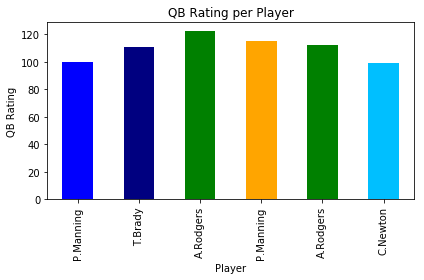

           Rating Index Team
Player                      
P.Manning             6  IND
T.Brady               1   NE
A.Rodgers             1   GB
P.Manning             2  DEN
A.Rodgers             2   GB
C.Newton              8  CAR
Minimum MVP quarterback rating: 99.2
Average Quarterback Rating is:  86.5


In [101]:
plot_stats('Rating', qb_df, 'Player', 'QB Rating')
print(rating_index)
print('Minimum MVP quarterback rating:', round(qb_df['Rating'].min(), 1))
print('Average Quarterback Rating is: ', round(df['Rating'].mean(), 1))

The next metric that was analysed was the yards gained. It can be seen that there quite a wide variety in the absolute value of yards gained per year per quarterback. The ranking of yards gained per quarterback showed a much clearer picture with 5 out of the 6 winners being in the top 8 quarterbacks for passing yards. The outlier in this group is Cam Newton in 2015. The reason for this was that Cam also gained anohter 636 yards running the ball. Cam is known as one of the most athletic quarterbacks in the league and his 2015 showed his dominance, not just throwing the ball, but also running the ball. He led all quarterbacks that year in rushing yards. 

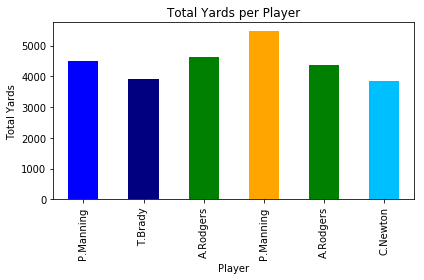

          Team  Yards Index
Player                     
P.Manning  IND            2
T.Brady     NE            8
A.Rodgers   GB            5
P.Manning  DEN            1
A.Rodgers   GB            7
C.Newton   CAR           16
Average Yards per Quarterback:  3188.0


In [102]:
plot_stats('Yards', qb_df, 'Player', 'Total Yards')
print(yards_index)
print('Average Yards per Quarterback: ', round(df['Yards'].mean(), 1))

The next metric measured was total touchdowns scored. It was seen that no MVP winner scored less than 33 touchdowns per season, which is more than an average of 2 touchdowns per game in a 16-game season. It was also seen that each quarterback was in the top 3 ranking for total number of touchdowns scored that season.

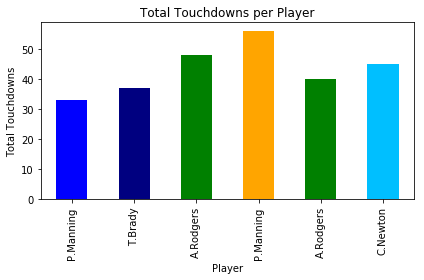

          Team  Touchdowns Index
Player                          
P.Manning  IND                 3
T.Brady     NE                 1
A.Rodgers   GB                 1
P.Manning  DEN                 1
A.Rodgers   GB                 2
C.Newton   CAR                 1
Average Total Touchdowns per Quarterback is:  21.4


In [103]:
plot_stats('Touchdowns', qb_df, 'Player', 'Total Touchdowns')
print(td_index)
print('Average Total Touchdowns per Quarterback is: ', round(df['Touchdowns'].mean(), 1))

Lastly, and arguably the most important metric, was total regular season wins. Each quarterback was a on a team that were the 1st or 2nd seeds going into the playoffs per conference. This means that their teams got a bye in the first round of the playoffs which has been shown to be incredibly important to getting to the Superbowl. 

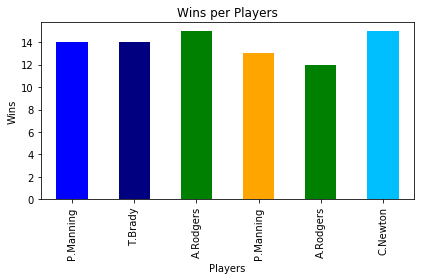

In [104]:
plot_stats('Wins', win_record, 'Players', 'Wins')

In conclusion, it can be seen that the important factors for quarterbacks in winning the MVP award are:
1. Top 3 in number of touchdowns.
2. 1st or 2nd seed in playoffs in either conference.
3. Top 8 in passing yards
4. Passer rating of 99 or higher.

In 2016, Matt Ryan won the MVP award with:
1. 2nd overall in number of touchdowns with 38.
2. 2nd seed in the NFC playoffs with 11 wins.
3. 2nd in passing yards.
4. Passer rating of 117.2.

In 2017, Tom Brady won the MVP award with:
1. 3rd overall in number of touchdowns with 32.
2. 1st seed in the AFC playoffs with 13 wins.
3. 1st in passing yards.
4. Passer rating of 102.8.

It can be seen that the next two winners of the MVP award are consistent with the model.